# PED Reader Notebook

This notebook supports the analysis of MT and MTPE projects. It provides the relevant Python code as well as notes for additional context to new users. The notebook takes JSON format data generated by the [Woerdle-zehla](https://github.com/SeeligA/woerdle-zehla "Measuring Post-Edit density for Studio files and Across LS exports") app as inputs and creates visualizations and post-processed tables as outputs.

**Prerequisites:**
* Previous knowledge of *Python* is not strictly required, but certainly helpful.
* If you know your way around the *commandline* and different flavours of *Regular Expressions* you should be fine. 

First, let's import the necessary scripts and objects from our project directory.

In [1]:
# The following two lines are for the creator of this notebook. Please ignore.
%load_ext autoreload
%autoreload 2
from source.table import create_df, build_query, filter_items, save_to_excel
from source.calculation import virtual_pe_density
from source.utils import plot, obj_to_dict, dict_to_obj
from source.subs import PreprocSub
from source.entries import SearchMTEntry, SearchSourceEntry, ToggleCaseEntry

## 1. Creating a dataset
First, we will create a table by iterating over the JSON files contained in the `data` directory. The table columns will be populated with items at the root level ("Relation", "Project" "Document", "s_lid", "t_lid") as well as the segment scores and string data at the ped_details level. We can then use any of the root-level items to create subsets using a custom query expression.

In [2]:
import pandas as pd
# Create table from file in data subfolder
df = create_df("data")
print(df.describe())
# Show the last 5 rows of the table
df.tail()

              score
count  24311.000000
mean   0.321493    
std    0.219114    
min    0.000000    
25%    0.155106    
50%    0.311404    
75%    0.461538    
max    1.000000    


,Project,Relation,Document,s_lid,t_lid,score,source,target,mt
24306,144450-4991,W.O.M. World of Medicine 4991,Service due_Messages_vorb.xlsx.sdlxliff,EN,PL,0.568182,| Please send to Stryker for service.,| Wyślij do firmy Stryker w celu przeglądu.,| Proszę wysłać do firmy Stryker do serwisu.
24307,144450-4991,W.O.M. World of Medicine 4991,Service due_Messages_vorb.xlsx.sdlxliff,EN,PL,0.000000,Tabelle1,Tabelle1,Tabelle1
24308,144450-4991,W.O.M. World of Medicine 4991,Service due_Messages_vorb.xlsx.sdlxliff,EN,PL,0.783784,Device service is due!,Nadszedł termin przeglądu urządzenia!,Obsługa urządzenia jest należna!
24309,144450-4991,W.O.M. World of Medicine 4991,Service due_Messages_vorb.xlsx.sdlxliff,EN,PL,0.376812,| Contact Stryker for service.,| Skontaktuj się z firmą Stryker w celu przeglądu.,| Skontaktuj się z firmą Stryker w celu uzyskania pomocy technicznej.
24310,144450-4991,W.O.M. World of Medicine 4991,Service due_Messages_vorb.xlsx.sdlxliff,EN,PL,0.820513,Device service is almost due!,Zbliża się termin przeglądu urządzenia!,Obsługa urządzenia jest prawie należna!


In order to create a query we will use a convenience function called ```build_query``` and pass it a dictionary of query  values. 

As an example: To query for data related to the clients *WMT_16_ped*, with target language ES and a PED score between zero and one use these key-value pairs:

```
filter_dict = {"Relation": ["WMT_16_ped"], 
               "t_lid": ["ES", "FR", "PT"], 
               "score": [0.0, 1]                            
              }
```
- - -
#### Notes
* Use quotes to assign text strings as keys or values. 
* A list of comma-separated values is expected.
* The ```score``` key requires numeric 2 values: a minimum and a maximum score (inclusive).

In [3]:
# TODO: Create a column dictionary for querying by assigning a list of values to a relevant keys.
filter_dict = {#"Relation": ["WMT_16_ped"], 
               "t_lid": ["ES"], 
               "Document": ["S0001.csv.sdlxliff", 
                            "S0004.csv.sdlxliff",
                            "S0016.csv.sdlxliff",
                            "S0021.csv.sdlxliff",
                            "S0025.csv.sdlxliff", 
                            "S0026.csv.sdlxliff",
                            "S0028.csv.sdlxliff"],
               "score": [0.0, 1]                            
              }

query = build_query(filter_dict)
data = df.query(query).copy()
# Calculate PED scores at a dataset-level and at a segment level and
# write the latter to a new column called "virtual". 
# At this stage, the new column should be identical to the "score" column.
ped = virtual_pe_density(data)
print('The aggregated PED for this dataset is {:f}'.format(ped))
data.head()

Query created:  (t_lid == "ES") & (Document == "S0001.csv.sdlxliff" or Document == "S0004.csv.sdlxliff" or Document == "S0016.csv.sdlxliff" or Document == "S0021.csv.sdlxliff" or Document == "S0025.csv.sdlxliff" or Document == "S0026.csv.sdlxliff" or Document == "S0028.csv.sdlxliff") & (score >= 0.0 & score <= 1)
The aggregated PED for this dataset is 0.421492


,Project,Relation,Document,s_lid,t_lid,score,source,target,mt,virtual
13783,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.370892,"The cardiovascular risk is responsible for a quarter splits of deaths by coronary illness and inside these patients, three quarter splits are greater than 65 years old.","El riesgo cardiovascular es responsable de una cuarta parte de las muertes por enfermedad coronaria y dentro de estos pacientes, tres cuartas partes son mayores de 65 años.","El riesgo cardiovascular es responsable de un cuarto de las muertes por enfermedad coronaria, y dentro de estos pacientes el 75% son mayores de 65 años de edad, población a la que nos enfocaremos en esta revisión.",0.370892
13784,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.184397,"Because of it, it's very important to consider the clinical and economic benefits of a preventive therapy in this population group.","Por ello, es muy importante considerar los beneficios clínicos y económicos de una terapia preventiva en este grupo de población.",Por ello es de suma importancia considerar tanto los beneficios clínicos como económicos de una terapia preventiva en este grupo poblacional.,0.184397
13785,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.635870,"Hypoglycemia (48%) was the most frequent complication followed by diabetic ketoacidosis (33%), hyperosmolar hyperglycemic state (17%) and finally lactic acidosis (2%).","La complicación más frecuente fue la hipoglucemia (48%), seguida de la cetoacidosis diabética (33%), el estado hiperglucémico hiperosmolar (17%) y finalmente la acidosis láctica (2%).","La más frecuente fue la hipoglucemia, que se observó en 48% de los pacientes. En menor cantidad, 33% con cetoacidosis diabética, 17% con estado hiperosmolar y 2% con acidosis láctica.",0.635870
13786,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.378788,Neurological and digestive were the main symptoms and most patients came from low socioeconomic level.,Los principales síntomas fueron neurológicos y digestivos y la mayoría de los pacientes procedían de un nivel socioeconómico bajo.,"Presentando principalmente manifestaciones neurológicas y digestivas, la mayoría de ellos provenientes de nivel socioeconómico bajo.",0.378788
13787,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.308081,Conclusions: Timely identification of the clinical manifestations of acute complications of diabetes allows better and faster attention avoiding severe complications.,Conclusiones: La identificación oportuna de las manifestaciones clínicas de las complicaciones agudas de la diabetes permite una atención mejor y más rápida evitando complicaciones graves.,"Conclusiones: La identificación oportuna de las características clínicas de las complicaciones agudas de la diabetes nos permite brindar atención rápida y eficaz, con lo que se evita mayor gravedad.",0.308081


## 2. Plotting post-edit density data
Now that we have prepared the data we're interested in, we can plot the distribution of post-edit density scores. Depending on our analysis question we might be interested in the total number of segments per bin or a normalized view of each bin. The KDE flag allows us to control the scaling. KDE stands for [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation "Kernel Density Estimation on Wikipedia"), a kind of rolling average plotted as a non-linear curve.

<img src="out\WMT16_sample.png" alt="Sample plot" width="400" align="right"/>


```
plot(data, cat_column="t_lid", 
     kde=True, 
     ped=ped, 
     save="out\\sample.png",
     linewidth=4 
     )
```


Try answering these questions:
* How does the distribution change as we specify different categorical values?
* Are there any features that seem to correlate with the post-edit density distribution?
* Do you think your dataset from above fits your question? Are there any other filter combinations you could try out?


Once you are satisfied with the items represented in your dataset, we can move on to the next step: MT quality evaluation.


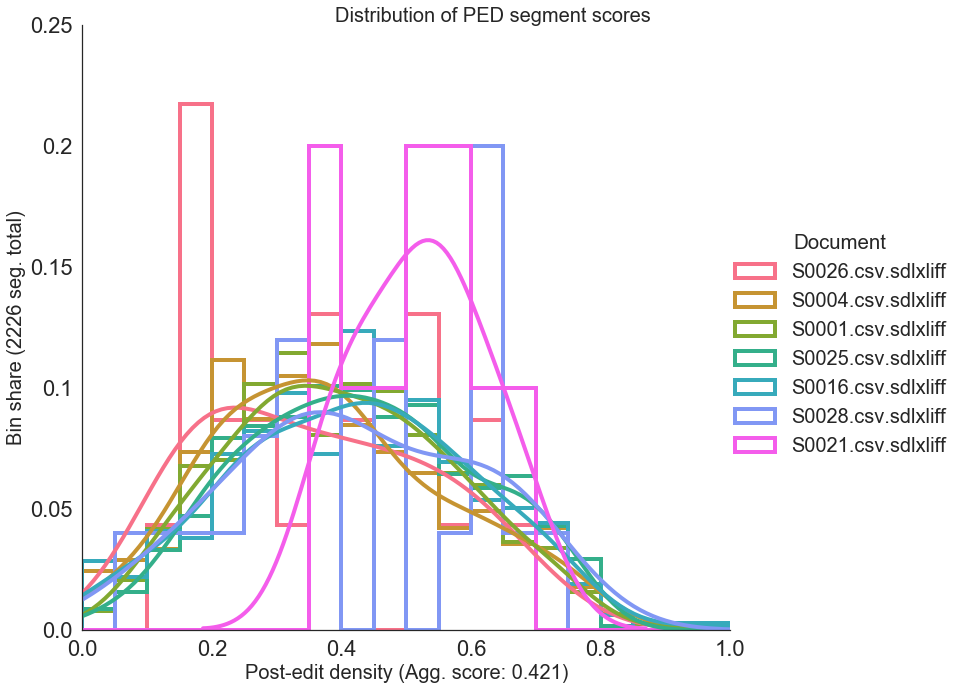

In [4]:
# TODO: Plot the post-edit density data using different columns names as categorical values.
# This works best with less than 10 categories per column. 
# Try plotting for source and target languages, relation or project IDs.

plot(data, cat_column="Document", 
     kde=True, 
     ped=ped, 
     #save="out\\WMT16_sample.png",
     linewidth=4 
     )

## 3. Quality evaluation
Quality evaluation (QE) is a two-step process to uncover error patterns in translated output. This is commonly done in a spreadsheet, but some CAT environments such as Trados Studio offer [integrations as well](https://www.youtube.com/watch?v=a2wid7Uxy54 "How to use Translation Quality Assessment in SDL Trados Studio 2019").

In a first step, we evaluate MT output against the source and a reference translation created by a linguist. In order to quantize a potentially infinite number of errors, we map our findings against a fixed-size **error typology**. In addition to that, we categorize errors depending on severity and project requirements. An important reference point used in translation services are the [Multidimensional Quality Metrics (MQM)](http://www.qt21.eu/mqm-definition/definition-2015-12-30.html "Multidimensional Quality Metrics (MQM) Definition") as well as MQM subsets such as the Dynamic Quality Framework (DQF).

- - -

Note: QEs are also used to evaluate the quality of a particular delivery. In this case, errors are counted, weighted and summed to produce an **error score**. This score is then divided by the word count to produce the **error rate**, which determines whether the delivery has __passed or failed__ the quality evaluation. While this type of QE often includes a summary to highlights features of the text and appreciates positive and negative aspects, analysing errors for structural patterns is beyond its scope.

- - -

In a second step, we look at the annotations from a bird's-eye view and try to determine common patterns and sources for errors. **Visualisations** can prove useful here, including *word clouds* and *bar charts* for types of error or *pie charts* for severity. If deemed practical, this can be followed up by another round of annotations and the cycle repeats.

For our purpose, quality evaluations result in two types of deliverables:
1. A report on the general quality detailing areas of focus and potential improvement strategies.
2. A list of resources, including *terminology items*, *replacement patterns*, *automated QA checks*, *additional instructions*, etc.

#### QUESTION:

Based on what has been said about the purpose of QE, how would you adapt the tools available to us to achieve these aims?

In [5]:
# Uncomment the next line to save your data to your working directory.
#save_to_excel(data, "out\\qe_data.xlsx")

## 4. Post-processing replacement patterns
Moving from analysis to action. There are three basic approaches to improving MT output:
* Engine re-training: This requires __access to the model parameters__.
* Pre-processing: This involves replacing or annotating tokens in the input __before applying an engine__.
* Post-processing: This involves __replacing tokens in the output__ based on search expressions or rules.

Post-processing can be combined with pre-processing or used on its own. In the following section we will focus on the latter approach.

### Creating rules
First, we will create a number a rules to find and replace incorrect terms. In the [entries](source/entries.py) module, there are three different objects we can choose from:
- SearchMTEntry -- Search and replace on the MT output only
- SearchSourceEntry -- Filter segments based on a source expression. Then perform search and replace on the MT output.
- ToggleCaseEntry -- Filter segments based on expected case and length of source. Then apply the case to the target.

An Entry object is characterized by its `search` and `replace` attributes. In addition to this, `SearchSourceEntry` and `ToggleCaseEntry` objects also feature a `source` attribute, which acts like a pre-filter for source strings.

In [6]:
a = SearchSourceEntry(1, "ASE", None, "Term: Methodology: methodología", "EN", "ES", "Materiales y métodos:", "Metodología", None, "^Methodology:")
b = SearchSourceEntry(1, "ASE", None, "Term: rupture: ruptura", "EN", "ES", "\\bperforación(?:e)?(s)?", "ruptura\\1", "\\b[Rr]upture")
c = SearchSourceEntry(1, "ASE", None, "Term: patients: pacientes", "EN", "ES", "\\bpersonas\\b", "pacientes", "\\bpatients\\b")
d = SearchSourceEntry(1, "ASE", None, "Term: defects: defectos", "EN", "ES", "\\bproblem(?:a)?(s)?\\b", "defecto\\1", "\\bdefect")
e = SearchSourceEntry(1, "ASE", None, "Term: Breeding season: temporada de reproducción", "EN", "ES", "\\bestación reproductiva\\b", "temporada de reproducción", "\\bbreeding season")
f = SearchSourceEntry(1, "ASE", None, "Term: lineage: linaje", "EN", "ES", "\\bencaste(s)?\\b", "linaje\\1", "\\blineage")
g = SearchMTEntry(1, "ASE", None, "Term: heterocigosis -> heterocigosidad", "EN", "ES", "\\bheterocigosis\\b", "heterocigosidad")
h = ToggleCaseEntry(999, "ASE", None, "Capitalize first character if this is reflected in the source", "All", "ES", 1, 'upper', None)

# To test the search and source 
# If you receive a UserWarning, please ignore it.
filter_items(exp=b.search, data=data, col="mt")

H:\02_working\05projects\01ped_reader\source\table.py:91: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  my_filter = data[col].str.contains(p, regex=True)


,Project,Relation,Document,s_lid,t_lid,score,source,target,mt,virtual
13789,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.381944,"Background: Appendiceal rupture is the most severe complication of acute appendicitis, since it has high morbidity and mortality rates.","Antecedentes: La ruptura del apéndice es la complicación más grave de la apendicitis aguda, ya que tiene altas tasas de morbilidad y mortalidad.",Antecedentes: La complicación más grave de la apendicitis aguda es la perforación debido a su alta morbilidad y mortalidad.,0.381944
13790,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.500000,"It has been suggested that the risk of appendiceal rupture is related to the time the patient takes to ask for medical help, previous medication, and te patient's type of insurance.","Se ha sugerido que el riesgo de ruptura del apéndice está relacionado con el tiempo que tarda el paciente en pedir ayuda médica, medicación previa y el tipo de seguro del paciente.","Se ha señalado que la probabilidad de perforación pudiera relacionarse al tiempo de demanda de atención, medicamentos previos a la atención médica y tipo de seguro del paciente.",0.500000
13791,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.212264,Objective: To establish the factors related to the appendiceal rupture in patients with acute appendicitis who attended the Centro Hospitalario Nuevo Sanatorio Durango from January 2008 to October 2012.,Objetivo: Establecer los factores relacionados con la rotura del apéndice en pacientes con apendicitis aguda que acudieron al Centro Hospitalario Nuevo Sanatorio Durango desde enero de 2008 hasta octubre de 2012.,Objetivo: Establecer los factores asociados a la perforación apendicular en pacientes con apendicitis aguda atendidos en el Centro Hospitalario Nuevo Sanatorio Durango entre enero del 2008 y octubre del 2012.,0.212264
13792,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.512315,Material and metodology: Patients who had undergone appendectomy for acute appendicitis were studied and 2 groups were formed: Appendiceal rupture group and Nonappendiceal rupture group.,Material y metodología: Se estudiaron los pacientes que se habían sometido a apendicectomía por apendicitis aguda y se formaron dos grupos: Grupo de ruptura apendicular y grupo de ruptura no apendicular.,Material y métodos: Se estudió a pacientes sometidos a cirugía por apendicitis aguda. Se agruparon según la presencia o no de perforación apendicular al momento del procedimiento quirúrgico.,0.512315
13794,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.604651,"Results: From 189 patients who underwent appendectomy for acute appendicitis, 69 (36%) presented appendiceal rupture.","Resultados: De 189 pacientes que se sometieron a apendicectomía por apendicitis aguda, 69 (36%) presentaron ruptura del apéndice.","Resultados: Se analizó un total de 189 expedientes, de los cuales, en 69 (36%) se presentó perforación apendicular.",0.604651
13796,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.536170,"These patients had two more hours of evolution (26 vs 24 horas, p<0.001) on average before receiving medical help; which meant 2% higher risk per hour (IC 95% de 0.2% a 4%, p = 0.03).","Estos pacientes tuvieron dos horas más de evolución (26 vs 24 horas, p<0.001) en promedio antes de recibir asistencia médica; lo que significó un 2% más de riesgo por hora (IC 95% de 0.2% a 4%, p = 0.03).","Los pacientes con perforación apendicular tuvieron 2 horas más en promedio de evolución previo a su atención (26 frente 24 horas, p < 0.001), lo cual significó 2% más de riesgo (RM) por hora transcurrida (IC 95% de 0.2 a 4%, p = 0.03).",0.536170
13798,test-gma-en2es-health,WMT_16_ped,S0026.csv.sdlxliff,EN,ES,0.172222,"Conclusions: the factors associated with appendiceal perforation were delay in medical attention, previous medication, and the type of insurance owned by the patient.","Conclusiones: los factores asoc

### Compiling substitution sets of rules
After creating some rules relevant to the error patterns found in the data, we are going to apply them and measure their impact on the PED. This includes: 
1. Creating a `PreprocSub` wrapper object to simplify applying and managing our set of entries.
2. Applying the set of entries to our data.
3. Recalculating the PED score for each segment.

Note that step three will provide us with updated scores for each entry. This is useful to determine the statistical impact of a rule. If a rule has little, no or a negative impact, we probably don't want to include it in our set of entries. Every time we apply an entry object to a table, its `ped_effect` attribute will be updated accordingly. 

In [7]:
subs_list = list([a,b,c,d,e,f,g,h])

subs = PreprocSub(created_by="ASE", desc="For WMT 16 testset (EN-ES)", entries=subs_list)
subs.apply_to_table(data, verbose=True)
print(subs.ped_effect)

Original PED:	0.421492
Updated PED:	0.421492	Term: Methodology: methodología
Updated PED:	0.421432	Term: rupture: ruptura
Updated PED:	0.421449	Term: patients: pacientes
Updated PED:	0.421435	Term: defects: defectos
Updated PED:	0.421386	Term: Breeding season: temporada de reproducción
Updated PED:	0.421378	Term: lineage: linaje
Updated PED:	0.421355	Term: heterocigosis -> heterocigosidad
Updated PED:	0.421355	Capitalize first character if this is reflected in the source
0.00013721251033188553


In [8]:
# Delete last entry == lowest or most negative PED effect
deleted = subs.entries.pop(-1)
deleted.desc

'Term: patients: pacientes'

Considering how marginal the PED gains are, what approach would you take to identify suitable candidate rules? Depending  on the size and homogeneity of your dataset, are any of the tools presented in [section 3](#3.-Quality-evaluation)  more or less useful than others?

### Serializing / deserializing substitution lists for storage
In order to store and reuse our set of entries, we use two convenience methods called `convert_to_json` and `load_from_json` that take care of serializing our custom objects. We use the JSON format, because it allows us to review and edit our set in a standard text editor.

To preview how your export will look like, run the following cell:
```
import json
print(json.dumps(subs.convert_to_json(), indent=4, ensure_ascii=False))
```
Note that entries have been re-indexed according to their PED effect on our dataset.

In [9]:
#import json
#print(json.dumps(subs.convert_to_json(), indent=4, ensure_ascii=False))

In [10]:
# Serialize list to disk
fp = "out\\wmt16_en-es.json"
subs.convert_to_json(fp);
# To deserialize simply pass in the file path:
new_subs = PreprocSub(fp=fp)

## 5. Conclusion
Let's summarize what we have done so far. We have seen how we can aggregate, visualize and export PED data to make better sense of our post-editing efforts. We have discussed how quality evaluation relates to our efforts to improve MT output incrementally. We then presented a small set of tools to create and test post-processing steps. This concludes this notebook. 

In the upcoming PED Writer notebook, we will apply our tools to translations within a CAT environment. Hope to see your there!

If you found any of this content helpful or confusing, please let me know. [mailto](mailto:arnseelig[at]gmail.com)

## Sources:
This notebook uses data from the [ACL 2016 Conference on Machine Translation](https://www.statmt.org/wmt16/biomedical-translation-task.html "Biomedical Translation Taks"). Please check the [full report](http://www.aclweb.org/anthology/W/W16/W16-2301 "@InProceedings{bojar-EtAl:2016:WMT1,
  author    = {Bojar, Ond\v{r}ej  and  Chatterjee, Rajen and Federmann, Christian  and  Graham, Yvette  and  Haddow, Barry  and  Huck, Matthias  and  Jimeno Yepes, Antonio  and  Koehn, Philipp  and  Logacheva, Varvara  and  Monz, Christof  and  Negri, Matteo  and  Neveol, Aurelie  and  Neves, Mariana  and  Popel, Martin  and  Post,  Matt  and  Rubino, Raphael  and  Scarton, Carolina  and  Specia,  Lucia  and  Turchi, Marco  and  Verspoor, Karin  and  Zampieri,  Marcos},
  title     = {Findings of the 2016 Conference on Machine Translation},
  booktitle = {Proceedings of the First Conference on Machine Translation},
  month     = {August},
  year      = {2016},
  address   = {Berlin, Germany},
  publisher = {Association for Computational Linguistics},
  pages     = {131--198},
  url       = {http://www.aclweb.org/anthology/W/W16/W16-2301}
}") to find out more about the data used for the Biomedical Translation Task and other tasks.